# SimCLR pre-trainind

## Installs and Imports

In [1]:
!pip install pytorch-lightning
!pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 KB 4.4 MB/s eta 0:00:0000:0100:01
  Using cached torch-2.5.1-cp310-cp310-manylinux1_x86_64.whl (906.4 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 KB 6.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 KB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 KB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 KB 4.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 KB 2.4 MB/s eta 0:00:0000:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependenc

In [3]:
! pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 12.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 5.6 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 KB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 21.2 MB/s eta 0:00:0000:0100:01


In [1]:
import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.multiprocessing import cpu_count
import torchvision.transforms as T

torch.__version__

'1.11.0+cu102'

In [2]:
! nvidia-smi

Mon Nov 25 13:59:52 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   30C    P8     9W / 250W |      2MiB / 12196MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def default(val, def_val):
    return def_val if val is None else val

def reproducibility(config):
    SEED = int(config.seed)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if (config.cuda):
        torch.cuda.manual_seed(SEED)


def device_as(t1, t2):
    """
    Moves t1 to the device of t2
    """
    return t1.to(t2.device)

def crop_to_match(a, b):
    """
    Crop tensor `a` to match the size of tensor `b`.
    """
    h_a, w_a = a.shape
    h_b, w_b = b.shape

    # Calculate cropping indices
    start_h = (h_a - h_b) // 2
    start_w = (w_a - w_b) // 2

    return a[start_h:start_h + h_b, start_w:start_w + w_b]

# From https://github.com/PyTorchLightning/pytorch-lightning/issues/924
def weights_update(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f'Checkpoint {checkpoint_path} was loaded')
    return model


class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, img_size, s=1):
        self.train_transform = T.transforms.Compose([
            T.RandomResizedCrop(img_size, scale=(0.3, 0.9), ratio=(3/4, 4/3)),
            T.RandomApply(
                    [T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                    p=0.8
                ),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([T.GaussianBlur(kernel_size=25, sigma=(0.1, 2.0))], p=0.5),
            T.Resize((256, 256)),
            T.CenterCrop(img_size),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        self.test_transform = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)



def get_stl_dataloader(batch_size, transform=None, split="unlabeled"):
    stl10 = STL10("./", split=split, transform=transform, download=True)
    return DataLoader(dataset=stl10, batch_size=batch_size, num_workers=cpu_count()//2)

def get_data_loader(dataset_path, batch_size, transform=None, shuffle=False):
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=cpu_count()//2)

import matplotlib.pyplot as plt

def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    def calc_similarity_batch(self, a, b):
        representations = torch.cat([a, b], dim=0)
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        # Resize mask to match shape of similarity_matrix
        if self.mask.shape[1] > similarity_matrix.shape[1]:
            self.mask = crop_to_match(self.mask, similarity_matrix)
        elif self.mask.shape[1] < similarity_matrix.shape[1]:
            self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(similarity_matrix.device)
        # Perform matrix multiplication
        denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

## Load dataset example

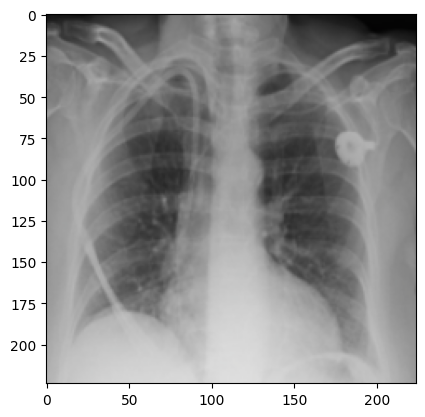

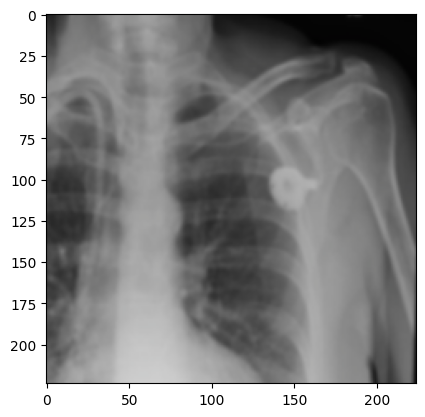

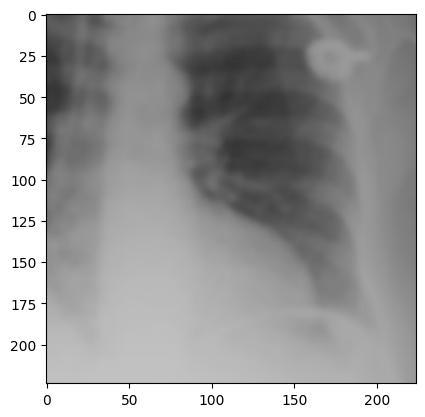

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.18039213..1.0000001].


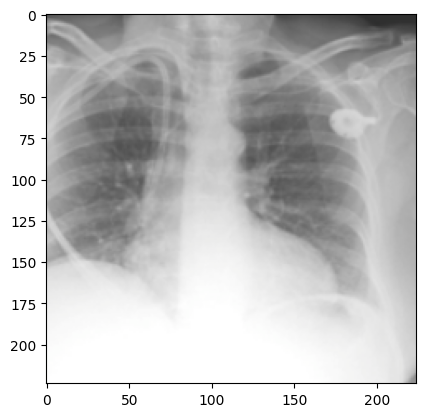

In [4]:
from torchvision import datasets

# Path to the dataset
dataset_path = './datasets/chestx-ray14-v3'

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=Augment(224))

imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])
imshow(dataset[99][0][0])

## Add projection Head for embedding and training logic with pytorch lightning model

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam
import gc

class AddProjection(nn.Module):
    def __init__(self, config, model=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = config.embedding_size
        self.backbone = default(model, models.efficientnet_b0(pretrained=False, num_classes=embedding_size))
        mlp_dim = default(mlp_dim, self.backbone.classifier[1].in_features) # use `classifier[1]` on efficientnet instead of `fc`
        print('Dim MLP input:', mlp_dim)
        self.backbone.classifier[1] = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
            nn.BatchNorm1d(mlp_dim),
            nn.ReLU(),
            nn.Linear(in_features=mlp_dim, out_features=embedding_size),
            nn.BatchNorm1d(embedding_size),
        )

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)



def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


class SimCLR_pl(pl.LightningModule):
    def __init__(self, config, model=None, feat_dim=512):
        super().__init__()
        self.config = config
        
        self.model = AddProjection(config, model=model, mlp_dim=feat_dim)

        self.loss = ContrastiveLoss(config.batch_size, temperature=self.config.temperature)

    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        (x1, x2), _ = batch
        z1 = self.model(x1)
        z2 = self.model(x2)
        loss = self.loss(z1, z2)
        self.log('Contrastive loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        max_epochs = int(self.config.epochs)
        param_groups = define_param_groups(self.model, self.config.weight_decay, 'adam')
        lr = self.config.lr
        optimizer = Adam(param_groups, lr=lr, weight_decay=self.config.weight_decay)

        print(f'Optimizer Adam, '
              f'Learning Rate {lr}, '
              f'Effective batch size {self.config.batch_size * self.config.gradient_accumulation_steps}')

        scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,
                                                         warmup_start_lr=0.0)

        return [optimizer], [scheduler_warmup]

/home/CIN/tta/msc-deep-learning/deep_learning/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/CIN/tta/msc-deep-learning/deep_learning/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/CIN/tta/msc-deep-learning/deep_learning/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/home/CIN/tta/msc-deep

## Config training

In [6]:
# a lazy way to pass the config file
class Hparams:
    def __init__(self):
        self.epochs = 100 # number of training epochs
        self.seed = 77777 # randomness seed
        self.cuda = True # use nvidia gpu
        self.img_size = 224 #image shape
        self.save = "./output/SimCLR/" # save checkpoint
        self.load = False # load pretrained checkpoint
        self.gradient_accumulation_steps = 5 # gradient accumulation steps
        self.batch_size = 64
        self.lr = 0.00025 # for Adam only
        self.weight_decay = 1e-6
        self.embedding_size= 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5
        self.checkpoint_path = None # replace checkpoint path here
        self.dataset_path = './datasets/chestx-ray14-v3'
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pre-training

In [7]:
import torch
from pytorch_lightning import Trainer
import os
from pytorch_lightning.callbacks import GradientAccumulationScheduler
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models import efficientnet_b0

available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
save_model_path = "./output/SimCLR"
print('available_gpus:',available_gpus)
filename='SimCLR_efficientnet_b0'
resume_from_checkpoint = False
train_config = Hparams()

reproducibility(train_config)
save_name = filename + '.ckpt'

eff_net = efficientnet_b0(pretrained=True)
model = SimCLR_pl(train_config, model=eff_net, feat_dim=None)

# Utilizar transform do DINO
transform = Augment(train_config.img_size)
data_loader = get_data_loader(train_config.dataset_path, train_config.batch_size, transform=transform)

accumulator = GradientAccumulationScheduler(scheduling={0: train_config.gradient_accumulation_steps})
checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path,every_n_epochs=20,
                                        save_last=True, save_top_k=1, monitor='Contrastive loss_epoch', mode='min')

if resume_from_checkpoint:
  trainer = Trainer(callbacks=[accumulator, checkpoint_callback],
                  gpus=available_gpus,
                  max_epochs=train_config.epochs,
                  resume_from_checkpoint=train_config.checkpoint_path)
else:
  trainer = Trainer(callbacks=[accumulator, checkpoint_callback],
                  gpus=available_gpus,
                  max_epochs=train_config.epochs)


trainer.fit(model, data_loader)

trainer.save_checkpoint(save_name)

available_gpus: 1
Dim MLP input: 1280


/home/CIN/tta/msc-deep-learning/deep_learning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/CIN/tta/msc-deep-learning/deep_learning/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory ./output/SimCLR exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/user/1781838319/ipykernel_1766677/937773821.py:86: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning pr

Optimizer Adam, Learning Rate 0.00025, Effective batch size 320


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Save results

In [9]:
model_pl = SimCLR_pl(train_config, model=efficientnet_b0(pretrained=False), feat_dim=None)
model_pl = weights_update(model_pl, f"{save_model_path}/SimCLR_efficientnet_b0.ckpt")

model_backbone_weights = model_pl.model.backbone
print(model_backbone_weights)
torch.save({
            'model_state_dict': model_backbone_weights.state_dict(),
            }, f'{save_model_path}/efficientnet_b0_backbone_weights.ckpt')

Dim MLP input: 1280
Checkpoint ./output/SimCLR/SimCLR_efficientnet_b0.ckpt was loaded
EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
    

## Fine-tuning

In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch

# Path to the dataset
dataset_path = './datasets/COVIDGR_1.0'
positive_path = os.path.join(dataset_path, 'P')
negative_path = os.path.join(dataset_path, 'N')

# Data transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.3, 0.9), ratio=(3/4, 4/3)),
    transforms.RandomApply(
            [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
            p=0.8
        ),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=25, sigma=(0.1, 2.0))], p=0.5),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Load dataset with ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

In [6]:
# Step 4: Map labels
dataset.class_to_idx = {'N': 0, 'P': 1}
dataset

Dataset ImageFolder
    Number of datapoints: 852
    Root location: ./datasets/COVIDGR_1.0
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.3, 0.9), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomApply(
               p=0.8
               ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.8, 1.2], hue=[-0.1, 0.1])
           )
               RandomGrayscale(p=0.2)
               RandomApply(
               p=0.5
               GaussianBlur(kernel_size=(25, 25), sigma=(0.1, 2.0))
           )
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [7]:
# Splitting the dataset
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
batch_size = 256
print(train_size, batch_size)

# Split off the test set
train_val_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader for the test set (held out)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

766 256


In [8]:
checkpoint_path = "./output/SimCLR/efficientnet_b0_backbone_weights.ckpt"
best_params = {"learning_rate": 0.01, "weight_decay": 0.001}

In [9]:
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim

def get_model():
    # Load the EfficientNet model
    model = efficientnet_b0()
    
    # Modify the final classification head for your dataset
    embed_dim = model.classifier[1].in_features
    model.classifier[1] = nn.Identity()
    
    # Load the pre-trained weights
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    
    # Remove unnecessary keys (e.g., DINO projection head weights)
    state_dict = checkpoint["model_state_dict"]  # Adjust the key if needed
    # remove `module.` prefix
    # state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    # state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    
    # Load the weights into the model
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(checkpoint_path, msg))

    # Freeze model params
    for param in model.features.parameters():
        param.requires_grad = False
    return model, embed_dim

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import time
from sklearn.model_selection import KFold

print (np.__version__)


def calculate_metrics(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1


def train_model(model, classifier, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    classifier = classifier.to(device)
    train_losses, val_losses = [], []
    best_val_f1 = 0.0

    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = classifier(outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        scheduler.step()  # Adjust learning rate

        # Validation phase
        classifier.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                outputs = classifier(outputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Metrics
        accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        if f1 > best_val_f1:
            best_val_f1 = f1

        print(f"[{device}] Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, F1 Score: {f1:.4f}")

    return best_val_f1

# Evaluate model on the test set
def evaluate_model(model, classifier, test_loader):
    classifier.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    classifier = classifier.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = classifier(outputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    return accuracy, precision, recall, f1

def grid_search(train_loader, val_loader, learning_rates, weight_decays, num_epochs):
    best_model = None
    best_f1 = 0
    best_params = {}
    for lr in learning_rates:
        for wd in weight_decays:
            model = get_model()
            optimizer = optim.SGD(model.classifier[1].parameters(), lr=lr, weight_decay=wd, momentum=0.9)
            scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, (epoch + 1) / 10))
            criterion = nn.CrossEntropyLoss()
            print(f"\nTraining with lr={lr}, weight_decay={wd}")
            f1_score = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = model
                best_params = {"learning_rate": lr, "weight_decay": wd}
    print(f"\nBest Model F1: {best_f1} with params {best_params}")
    return best_model, best_params

# Step 9: 5-Fold Cross-Validation
def cross_validation(best_params, dataset, test_loader, num_epochs=50, folds=5):
    fold_metrics = []
    kfold = KFold(n_splits=folds, shuffle=True, random_state=100)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\nStarting fold {fold + 1}/{folds}")

        # Split dataset indices for training and validation
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders for this fold
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model, embed_dim = get_model()
        linear_classifier = nn.Linear(embed_dim, 2) # 2 is the number of features
        optimizer = optim.SGD(linear_classifier.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'], momentum=0.9)
        scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: min(1.0, (epoch + 1) / 10))
        criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        _ = train_model(model, linear_classifier, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)
        end_time = time.time()

        # Evaluate on test set
        accuracy, precision, recall, f1 = evaluate_model(model, linear_classifier, test_loader)
        fold_metrics.append((accuracy, precision, recall, f1, end_time - start_time))

    return np.array(fold_metrics)

1.26.4


In [11]:
# Run the 5-fold cross-validation
metrics = cross_validation(best_params, train_val_dataset, test_loader, num_epochs=50, folds=5)

# Calculate average and standard deviation of metrics across folds
avg_metrics = metrics.mean(axis=0)
std_metrics = metrics.std(axis=0)

print(f"\nAverage metrics over 5 folds in test set:\n"
      f"Accuracy: {avg_metrics[0]:.4f} ± {std_metrics[0]:.4f}\n"
      f"Precision: {avg_metrics[1]:.4f} ± {std_metrics[1]:.4f}\n"
      f"Recall: {avg_metrics[2]:.4f} ± {std_metrics[2]:.4f}\n"
      f"F1 Score: {avg_metrics[3]:.4f} ± {std_metrics[3]:.4f}\n"
      f"Training Time per Fold: {avg_metrics[4]:.2f} ± {std_metrics[4]:.2f} seconds")


Starting fold 1/5
Pretrained weights found at ./output/SimCLR/efficientnet_b0_backbone_weights.ckpt and loaded with msg: <All keys matched successfully>
[cuda] Epoch 1/50, Train Loss: 0.7553, Val Loss: 0.7520, F1 Score: 0.3649
[cuda] Epoch 2/50, Train Loss: 0.7368, Val Loss: 0.6880, F1 Score: 0.4698
[cuda] Epoch 3/50, Train Loss: 0.6743, Val Loss: 0.6222, F1 Score: 0.7000
[cuda] Epoch 4/50, Train Loss: 0.6101, Val Loss: 0.5701, F1 Score: 0.7114
[cuda] Epoch 5/50, Train Loss: 0.5681, Val Loss: 0.5335, F1 Score: 0.7383
[cuda] Epoch 6/50, Train Loss: 0.5640, Val Loss: 0.5417, F1 Score: 0.7467
[cuda] Epoch 7/50, Train Loss: 0.5679, Val Loss: 0.5472, F1 Score: 0.7361
[cuda] Epoch 8/50, Train Loss: 0.5683, Val Loss: 0.5353, F1 Score: 0.7075
[cuda] Epoch 9/50, Train Loss: 0.5590, Val Loss: 0.5687, F1 Score: 0.6906
[cuda] Epoch 10/50, Train Loss: 0.5178, Val Loss: 0.5972, F1 Score: 0.6806
[cuda] Epoch 11/50, Train Loss: 0.5471, Val Loss: 0.5611, F1 Score: 0.6892
[cuda] Epoch 12/50, Train Loss

In [12]:
metrics

array([[7.09302326e-01, 6.34146341e-01, 7.22222222e-01, 6.75324675e-01,
        2.01399432e+03],
       [7.20930233e-01, 6.30434783e-01, 8.05555556e-01, 7.07317073e-01,
        1.99994082e+03],
       [7.20930233e-01, 6.25000000e-01, 8.33333333e-01, 7.14285714e-01,
        1.98010761e+03],
       [7.09302326e-01, 6.27906977e-01, 7.50000000e-01, 6.83544304e-01,
        1.99762275e+03],
       [7.09302326e-01, 6.22222222e-01, 7.77777778e-01, 6.91358025e-01,
        2.00553035e+03]])

In [13]:
import pandas as pd

results = pd.DataFrame(metrics, columns=['accuracy', 'precision', 'recall', 'f1', 'training time'])
results.head()

,accuracy,precision,recall,f1,training time
0,0.709302,0.634146,0.722222,0.675325,2013.994318
1,0.720930,0.630435,0.805556,0.707317,1999.940824
2,0.720930,0.625000,0.833333,0.714286,1980.107611
3,0.709302,0.627907,0.750000,0.683544,1997.622747
4,0.709302,0.622222,0.777778,0.691358,2005.530348


In [14]:
results.to_csv('./results/simclr_fine_tuned.csv')